In [1]:
%matplotlib inline
import cv2
from theano import *
theano.config.openmp = True

from keras import *
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
import h5py

import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import *
from keras.applications.vgg16 import VGG16

Using Theano backend.


In [2]:
fobia_folder = "./trypophobic/"
normal_folder = "./data_train/reddit_sub_pics/"
resolution_x = 224
resolution_y = 224
def load_folder(folder):
    
    images = []
    
    if(not os.path.isdir(folder[:-1]+"-parsed")):
        os.mkdir(folder[:-1]+"-parsed")
    
    for file in tqdm(os.listdir(folder)):
        image = cv2.imread(os.path.join(folder, file))
        if(image is not None):
            image = cv2.resize(image, (resolution_x, resolution_y), interpolation=cv2.INTER_LINEAR)
            cv2.imwrite(os.path.join(folder[:-1]+"-parsed/",file), image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image.reshape(3,resolution_x, resolution_y))
    images = np.array(images)
    return images

In [3]:
fobia_images = load_folder(fobia_folder).astype(np.float32) /255.
normal_images = load_folder(normal_folder).astype(np.float32) /255.

100%|██████████| 848/848 [00:51<00:00, 16.51it/s]


In [4]:
data_y = [] # 1,0 -> fobia | 0,1 -> normal
data_x = []
for img in fobia_images:
    data_x.append(img)
    data_y.append([1,0])
for img in normal_images:
    data_x.append(img)
    data_y.append([0,1])

data_x = np.array(data_x)
data_y = np.array(data_y)

X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=4)

datagen = ImageDataGenerator(
   rotation_range=20,
   horizontal_flip=True,
   dim_ordering="th")

In [5]:
#
#FAJNE DZIALAJACE 
#68% val_acc
#
model = models.Sequential()
#model.add(layers.Convolution2D(nb_filter=1, nb_col=1, nb_row=1,
#                               input_shape=(3,resolution_x,resolution_y),
#                               dim_ordering="th"))
#model.add(layers.Activation(activation="relu"))
#---------------------------------------------
model.add(layers.Convolution2D(nb_filter=8, nb_col=10, nb_row=10, 
                               dim_ordering="th", 
                               input_shape=(3,resolution_x,resolution_y)))
model.add(layers.Activation(activation="relu"))
model.add(layers.MaxPooling2D(dim_ordering="th", pool_size=(5,5)))
model.add(layers.Dropout(0.1))
#---------------------------------------------
model.add(layers.Convolution2D(nb_filter=8, nb_col=3, nb_row=3,
                              dim_ordering="th"))
model.add(layers.Activation(activation="relu"))
model.add(layers.MaxPooling2D(dim_ordering="th", pool_size=(5,5)))
model.add(layers.Dropout(0.1))
#---------------------------------------------
model.add(layers.Convolution2D(nb_filter=8, nb_col=3, nb_row=3,
                              dim_ordering="th"))
model.add(layers.Activation(activation="relu"))
#---------------------------------------------
model.add(layers.Convolution2D(nb_filter=8, nb_col=3, nb_row=3,
                              dim_ordering="th"))
model.add(layers.Activation(activation="relu"))
#---------------------------------------------
model.add(layers.GlobalMaxPooling2D(dim_ordering="th"))
#model.add(layers.MaxPooling2D(dim_ordering="th", pool_size=(3,3)))
#model.add(layers.Convolution2D(nb_filter=8, nb_col=3, nb_row=3))
#model.add(layers.Activation(activation="relu"))
#model.add(layers.MaxPooling2D(dim_ordering="th", pool_size=(3,3)))
#model.add(layers.Flatten())
#model.add(layers.Dense(16))
#model.add(layers.Activation(activation="relu"))
model.add(layers.Dense(2))
model.add(layers.Activation(activation="softmax"))

In [6]:
#Copied from
#https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
#---------------------------------------------------------------

def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

# Test pretrained model
model = VGG_16('vgg16_weights.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
#optimizer = "adam"#optimizers.SGD(lr=0.1, momentum=0.01, nesterov=True)
#model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=1),
                    samples_per_epoch=len(X_train), nb_epoch=5, validation_data=(X_test, Y_test))

INFO (theano.gof.compilelock): Refreshing lock /home/grzegorz/.theano/compiledir_Linux-4.8--ARCH-x86_64-with-arch--3.6.0-64/lock_dir/lock
Problem occurred during compilation with the command line below:
/usr/bin/g++ -shared -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -march=ivybridge -mmmx -mno-3dnow -msse -msse2 -msse3 -mssse3 -mno-sse4a -mcx16 -msahf -mno-movbe -maes -mno-sha -mpclmul -mpopcnt -mno-abm -mno-lwp -mno-fma -mno-fma4 -mno-xop -mno-bmi -mno-bmi2 -mno-tbm -mavx -mno-avx2 -msse4.2 -msse4.1 -mno-lzcnt -mno-rtm -mno-hle -mrdrnd -mf16c -mfsgsbase -mno-rdseed -mno-prfchw -mno-adx -mfxsr -mxsave -mxsaveopt -mno-avx512f -mno-avx512er -mno-avx512cd -mno-avx512pf -mno-prefetchwt1 -mno-clflushopt -mno-xsavec -mno-xsaves -mno-avx512dq -mno-avx512bw -mno-avx512vl -mno-avx512ifma -mno-avx512vbmi -mno-clwb -mno-mwaitx -mno-clzero -mno-pku --param l1-cache-size=32 --param l1-cache-line-size=64 --param l2-cache-size=3072 -mtune=ivybridge -DNPY_NO_DEPRE

OSError: [Errno 12] Cannot allocate memory

In [9]:
model.save("pretraining.h5")

(8, 10, 10, 3)


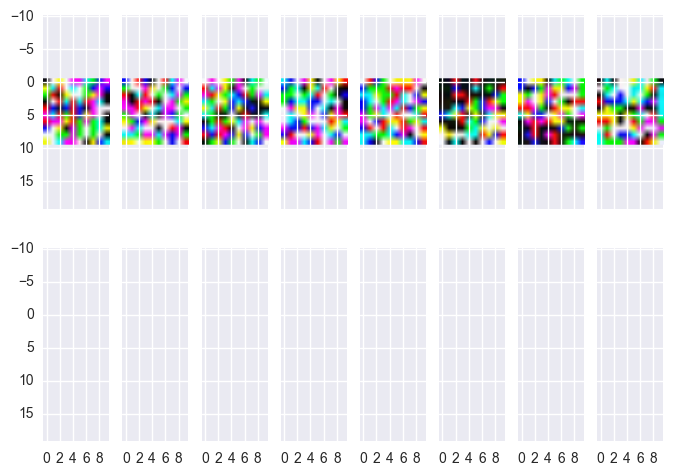

In [10]:
weights = model.layers[0].W.get_value(borrow=True).reshape(8,10,10,3)
print (weights.shape)
fig, axes = plt.subplots(2,8, sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = (10,5)
for i,w in enumerate(weights):
    axes[int(i/8)][int(i%8)].imshow(w)
    if(i == 31):
        break
plt.show()

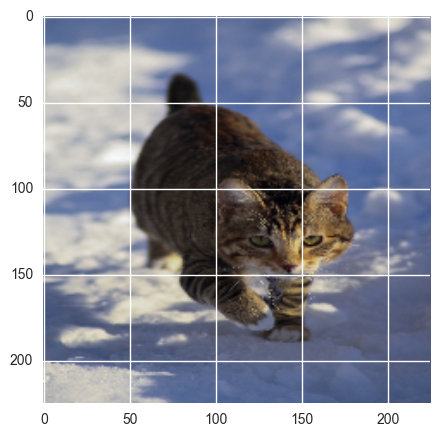

In [13]:
np.random.seed(4)
sample_image = X_test[np.random.randint(0, len(X_test))]
plt.imshow(sample_image.reshape(resolution_x, resolution_y, 3))
plt.show()

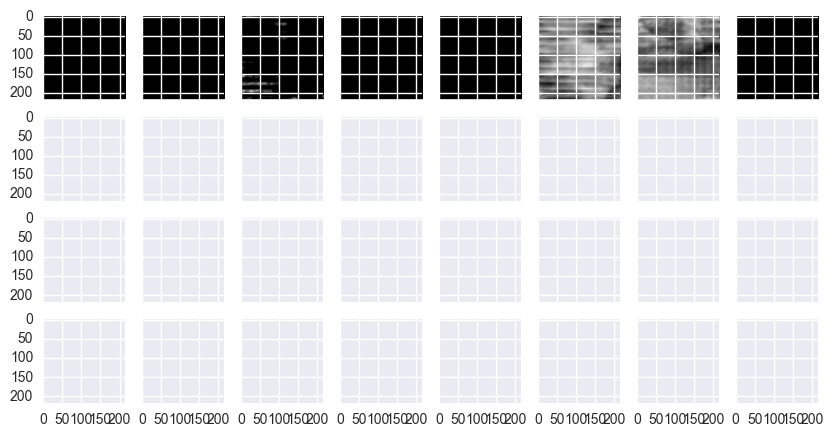

In [15]:
convout1_f = theano.function(model.inputs, [model.layers[1].output])
sample_outs = convout1_f([sample_image.astype(np.float32)])[0][0]

fig, axes = plt.subplots(4,8, sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = (10, 5)
for i,w in enumerate(sample_outs):
    axes[int(i/8)][int(i%8)].imshow(w, cmap="gray")
    #sns.heatmap(w)
    #plt.show()
plt.show()